In [1]:
import numpy as np
import sys
sys.path.append('/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis')  # Add parent directory to path for module imports
import helper_functions
import json
import pandas as pd

In [2]:
df_e198 = pd.read_excel("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08020/Network/000024/well005/metrics_curated.xlsx")

df_e200 = pd.read_excel("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M05506/Network/000028/well003/metrics_curated.xlsx")

df_healthy = pd.read_excel("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08018/Network/000021/well003/metrics_curated.xlsx")

In [3]:
df_healthy['NeuronType'] = 'Healthy'
df_e198['NeuronType'] = "E198K"
df_e200["NeuronType"] = "E200K"

In [4]:
df_all = pd.concat([df_healthy,df_e198,df_e200],axis=0,ignore_index=True)

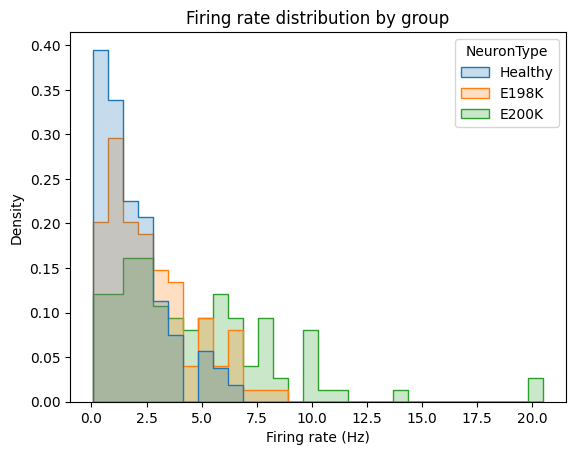

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure()
sns.histplot(
    data=df_all,
    x='firing_rate',
    hue='NeuronType',
    bins=30,
    element='step',
    stat='density',
    common_norm=False
)
plt.xlabel('Firing rate (Hz)')
plt.ylabel('Density')
plt.title('Firing rate distribution by group')
plt.show()

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x, y=y, order=order, palette=palette,
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x=x, y=y, order=order, palette=palette,


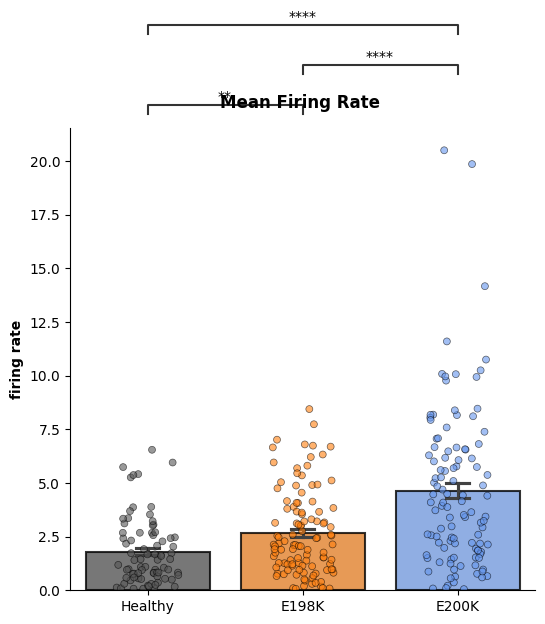

In [6]:
import importlib
import meaplotter
importlib.reload(meaplotter)

# The Vibrant Palette from your image
vibrant_palette = {
    'Healthy': '#555555',       # Dark gray (the bar in your image)
    'E198K': '#ff7f0e',         # Vibrant orange
    'E200K': 'cornflowerblue'   # Vibrant blue
}

# Initialize
viz = meaplotter.MEAPlotter()

# 1. ANALYZE (Get the numbers)


# 2. PLOT (Just visualize in Jupyter)
fig, ax = plt.subplots(figsize=(6,6))

viz.plot_bars(
    df=df_all,
    x='NeuronType',
    y='firing_rate',
    order=['Healthy', 'E198K', 'E200K'],
    palette=vibrant_palette,
    title="Mean Firing Rate ",
    ax=ax
)
plt.show()
# stats_df = viz.calculate_stats(
#     df=df_well_means, 
#     x='NeuronType', 
#     y='firing_rate',
#     order=['Healthy', 'E198K', 'E200K']
# )
# # print(stats_df) # View stats if you want
# # 3. SAVE PDF (Optional: Combine both into a report)
# viz.save_pdf(
#     df=df_well_means,
#     x='NeuronType',
#     y='firing_rate',
#     order=['Healthy', 'E198K', 'E200K'],
#     palette=vibrant_palette,
#     stats_df=stats_df,  # Pass the stats you calculated in step 1
#     title="Mean Firing Rate",
#     filename="/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/Firing_Rate_Report.pdf"
# )

In [7]:
df_all.columns

Index(['Unnamed: 0', 'num_spikes', 'firing_rate', 'presence_ratio', 'snr',
       'isi_violations_ratio', 'isi_violations_count', 'rp_contamination',
       'rp_violations', 'sliding_rp_violation', 'amplitude_cutoff',
       'amplitude_median', 'amplitude_cv_median', 'amplitude_cv_range',
       'sync_spike_2', 'sync_spike_4', 'sync_spike_8', 'firing_range',
       'sd_ratio', 'noise_cutoff', 'noise_ratio', 'loc_x', 'loc_y',
       'NeuronType'],
      dtype='object')

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x, y=y, order=order, palette=palette,
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x=x, y=y, order=order, palette=palette,


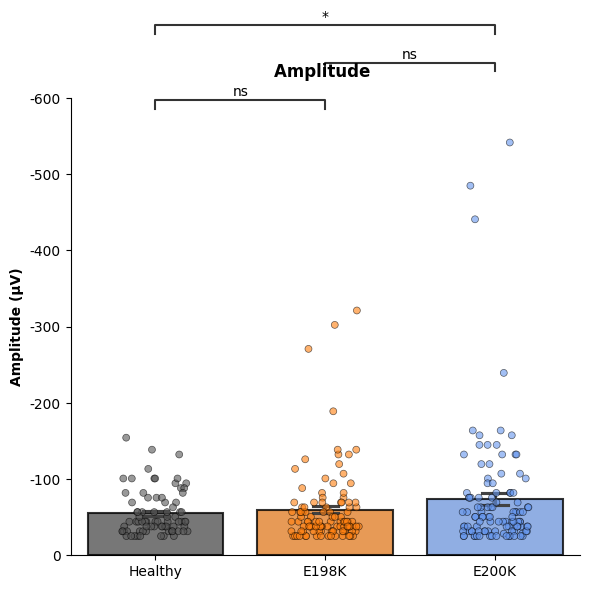

In [15]:
# Initialize
viz = meaplotter.MEAPlotter()

# 1. ANALYZE (Get the numbers)


# 2. PLOT (Just visualize in Jupyter)
fig, ax = plt.subplots(figsize=(6,6))
df_all['amplitude_median_abs'] = df_all['amplitude_median'].abs()  # Create a new column with absolute values for plotting

viz.plot_bars(
    df=df_all,
    x='NeuronType',
    y='amplitude_median_abs',
    order=['Healthy', 'E198K', 'E200K'],
    palette=vibrant_palette,
    title="Amplitude ",
    ax=ax
)
yticks = ax.get_yticks()
ax.set_yticks(yticks) # Lock the ticks
ax.set_yticklabels([f"-{int(y)}" if y > 0 else "0" for y in yticks])

plt.ylabel('Amplitude (µV)', fontweight='bold')
plt.tight_layout()
plt.show()


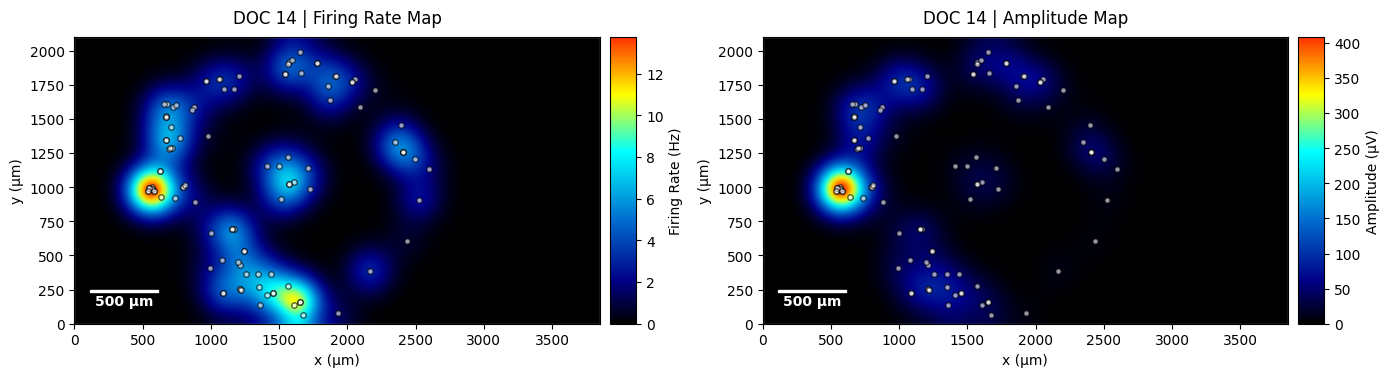

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1 import make_axes_locatable

plot_here = 'e200k'

df_here =df_e200.copy()
file_path = f'/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/spikesorted_unit_maps_{plot_here}_DOC14.svg'
# -----------------------------
# 1. Setup Parameters
# -----------------------------
ACTIVE_W = 3850   
ACTIVE_H = 2100   
SCALE_BAR = 500   
SIGMA_UM = 120    
BIN_SIZE = 20     

# -----------------------------
# 2. Load Data (Assumes df_e198 exists)
# -----------------------------
# Ensure df_e198 is loaded!
x = df_here['loc_x'].values
y = df_here['loc_y'].values
fr = df_here['firing_rate'].values

# Handle Amplitude (Absolute Value)
if 'amplitude_median' in df_here.columns:
    # Use 98th percentile as the "Max" to avoid one crazy outlier skewing the scale
    amp = np.abs(df_here['amplitude_median'].values)
    amp_max_target = np.percentile(amp, 98) 
else:
    amp = fr
    amp_max_target = np.percentile(fr, 98)

fr_max_target = np.percentile(fr, 98) # Target max for Firing Rate

# -----------------------------
# 3. Helper Functions
# -----------------------------
def get_maxwell_cmap():
    colors = [(0.0, 'black'), (0.15, '#000088'), (0.35, '#0066cc'),
              (0.6, '#00ffff'), (0.8, '#ffff00'), (1.0, '#ff3300')]
    return LinearSegmentedColormap.from_list('maxwell_amp', colors)

def make_heatmap(x_vals, y_vals, weights, width, height, sigma_um, bin_size, max_target):
    """
    Generates a map and re-normalizes it so the peak intensity matches 'max_target'.
    """
    # 1. Create Grid
    x_bins = np.arange(0, width + bin_size, bin_size)
    y_bins = np.arange(0, height + bin_size, bin_size)
    
    # 2. Weighted Histogram (The sparse map)
    heatmap, _, _ = np.histogram2d(x_vals, y_vals, bins=[x_bins, y_bins], weights=weights)
    
    # 3. Gaussian Smoothing (This lowers the values)
    sigma_pixel = sigma_um / bin_size
    heatmap_smooth = gaussian_filter(heatmap.T, sigma=sigma_pixel)
    
    # 4. RE-NORMALIZATION (The Fix)
    # Scale the map so the highest peak matches the real data's top 2%
    current_max = np.max(heatmap_smooth)
    if current_max > 0:
        heatmap_norm = heatmap_smooth * (max_target / current_max)
    else:
        heatmap_norm = heatmap_smooth
        
    return heatmap_norm

# -----------------------------
# 4. Plotting
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))
maxwell_cmap = get_maxwell_cmap()

configs = [
    {
        'ax': axes[0], 
        'data': fr,  
        'target': fr_max_target, # Pass the real data max (e.g. 8.0 Hz)
        'title': 'Firing Rate Map', 
        'cbar': 'Firing Rate (Hz)'
    },
    {
        'ax': axes[1], 
        'data': amp, 
        'target': amp_max_target, # Pass the real data max (e.g. 300 uV)
        'title': 'Amplitude Map',       
        'cbar': 'Amplitude (µV)'
    }
]

for conf in configs:
    ax = conf['ax']
    data_weights = conf['data']
    
    # Generate Map with Normalization
    # We pass the real data maximum (target) into the function
    heatmap_final = make_heatmap(x, y, data_weights, ACTIVE_W, ACTIVE_H, SIGMA_UM, BIN_SIZE, conf['target'])
    
    # Plot Image
    img = ax.imshow(
        heatmap_final, 
        extent=[0, ACTIVE_W, 0, ACTIVE_H], 
        origin='lower', 
        cmap=maxwell_cmap, 
        vmin=0, 
        vmax=conf['target'], # Set scale to match the data target
        interpolation='bicubic'
    )
    
    # Overlay Dots
    ax.scatter(x, y, s=15, facecolors='white', edgecolors='black', alpha=0.6)

    # Scale Bar
    scalebar = AnchoredSizeBar(ax.transData, SCALE_BAR, f'{SCALE_BAR} µm', 'lower left', 
                               pad=1, color='white', frameon=False, size_vertical=ACTIVE_H * 0.005,
                               fontproperties={'weight': 'bold', 'size': 10})
    ax.add_artist(scalebar)
    
    # Formatting
    ax.set_facecolor('black')
    ax.set_title(f"DOC 14 | {conf['title']}", fontsize=12, pad=10)
    ax.set_xlabel('x (µm)')
    ax.set_ylabel('y (µm)')
    ax.set_xlim(0, ACTIVE_W)
    ax.set_ylim(0, ACTIVE_H)
    ax.add_patch(Rectangle((0, 0), ACTIVE_W, ACTIVE_H, fill=False, edgecolor='white', lw=1, alpha=0.5))
    
    # Perfect Fit Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(img, cax=cax)
    cbar.set_label(conf['cbar'])

plt.tight_layout()
plt.savefig(file_path, dpi=300,format='svg')
plt.show()

In [2]:
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Setup Paths
# ---------------------------------------------------------
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08018/Network/000021/"
output_filename = "merged_metrics_healthy.xlsx"

# Define the range of wells (well000 to well005)
wells = [f"well{i:03d}" for i in range(6)]

# ---------------------------------------------------------
# 2. Collect and Merge Data
# ---------------------------------------------------------
dfs = []

print(f"Scanning directories in: {base_path}\n")

for well in wells:
    # Construct the full file path
    file_path = os.path.join(base_path, well, "metrics_curated.xlsx")
    
    if os.path.exists(file_path):
        try:
            # Load the Excel file
            df = pd.read_excel(file_path)
            
            # Add a 'Well' column so you know which file the row came from
            df.insert(0, 'Source_Well', well)
            
            # Add to list
            dfs.append(df)
            print(f"[SUCCESS] Loaded: {well}/metrics_curated.xlsx ({len(df)} rows)")
            
        except Exception as e:
            print(f"[ERROR] Could not read {well}: {e}")
    else:
        print(f"[WARNING] File not found: {file_path}")

# ---------------------------------------------------------
# 3. Concatenate and Save
# ---------------------------------------------------------
if dfs:
    merged_df_healthy = pd.concat(dfs, ignore_index=True)
    
    # Save the merged file to the base directory
    output_path = os.path.join(base_path, output_filename)
    merged_df_healthy["NeuronType"] = "Healthy"  # Add NeuronType column with "Healthy" value
    merged_df_healthy.to_excel(output_path, index=False)
    
    print("-" * 50)
    print(f"Merge Complete!")
    print(f"Total Rows: {len(merged_df_healthy)}")
    print(f"Saved to:   {output_path}")
    
    # Display first few rows
    print("\nPreview of merged data:")
    print(merged_df_healthy.head())
else:
    print("\n[ERROR] No files were loaded. Please check your paths.")

Scanning directories in: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08018/Network/000021/

[SUCCESS] Loaded: well000/metrics_curated.xlsx (64 rows)
[SUCCESS] Loaded: well001/metrics_curated.xlsx (118 rows)
[SUCCESS] Loaded: well002/metrics_curated.xlsx (135 rows)
[SUCCESS] Loaded: well003/metrics_curated.xlsx (78 rows)
[WARNING] File not found: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08018/Network/000021/well004/metrics_curated.xlsx
[SUCCESS] Loaded: well005/metrics_curated.xlsx (139 rows)
--------------------------------------------------
Merge Complete!
Total Rows: 534
Saved to:   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08018/Network/000021/merged_metrics_healthy.xlsx

Preview of merged data:
  Source_Well  Unnamed: 0  num_spikes  firing_rate  presence_r

In [3]:
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Setup Paths
# ---------------------------------------------------------
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08020/Network/000024/"
output_filename = "merged_metrics_e198.xlsx"

# Define the range of wells (well000 to well005)
wells = [f"well{i:03d}" for i in range(6)]

# ---------------------------------------------------------
# 2. Collect and Merge Data
# ---------------------------------------------------------
dfs = []

print(f"Scanning directories in: {base_path}\n")

for well in wells:
    # Construct the full file path
    file_path = os.path.join(base_path, well, "metrics_curated.xlsx")
    
    if os.path.exists(file_path):
        try:
            # Load the Excel file
            df = pd.read_excel(file_path)
            
            # Add a 'Well' column so you know which file the row came from
            df.insert(0, 'Source_Well', well)
            
            # Add to list
            dfs.append(df)
            print(f"[SUCCESS] Loaded: {well}/metrics_curated.xlsx ({len(df)} rows)")
            
        except Exception as e:
            print(f"[ERROR] Could not read {well}: {e}")
    else:
        print(f"[WARNING] File not found: {file_path}")

# ---------------------------------------------------------
# 3. Concatenate and Save
# ---------------------------------------------------------
if dfs:
    merged_df_e198 = pd.concat(dfs, ignore_index=True)
    
    # Save the merged file to the base directory
    output_path = os.path.join(base_path, output_filename)
    merged_df_e198["NeuronType"] = "E198K"  # Add NeuronType column with "E198" value
    merged_df_e198.to_excel(output_path, index=False)
    
    print("-" * 50)
    print(f"Merge Complete!")
    print(f"Total Rows: {len(merged_df_e198)}")
    print(f"Saved to:   {output_path}")
    
    # Display first few rows
    print("\nPreview of merged data:")
    print(merged_df_e198.head())
else:
    print("\n[ERROR] No files were loaded. Please check your paths.")

Scanning directories in: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08020/Network/000024/

[SUCCESS] Loaded: well000/metrics_curated.xlsx (206 rows)
[SUCCESS] Loaded: well001/metrics_curated.xlsx (157 rows)
[SUCCESS] Loaded: well002/metrics_curated.xlsx (151 rows)
[SUCCESS] Loaded: well003/metrics_curated.xlsx (141 rows)
[SUCCESS] Loaded: well004/metrics_curated.xlsx (99 rows)
[SUCCESS] Loaded: well005/metrics_curated.xlsx (109 rows)
--------------------------------------------------
Merge Complete!
Total Rows: 863
Saved to:   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08020/Network/000024/merged_metrics_e198.xlsx

Preview of merged data:
  Source_Well  Unnamed: 0  num_spikes  firing_rate  presence_ratio        snr  \
0     well000           1        1637     5.456667             1.0  11.134492   
1     well000           3         706  

In [4]:
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Setup Paths
# ---------------------------------------------------------
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M05506/Network/000028/"
output_filename = "merged_metrics_e200.xlsx"

# Define the range of wells (well000 to well005)
wells = [f"well{i:03d}" for i in range(6)]

# ---------------------------------------------------------
# 2. Collect and Merge Data
# ---------------------------------------------------------
dfs = []

print(f"Scanning directories in: {base_path}\n")

for well in wells:
    # Construct the full file path
    file_path = os.path.join(base_path, well, "metrics_curated.xlsx")
    
    if os.path.exists(file_path):
        try:
            # Load the Excel file
            df = pd.read_excel(file_path)
            
            # Add a 'Well' column so you know which file the row came from
            df.insert(0, 'Source_Well', well)
            
            # Add to list
            dfs.append(df)
            print(f"[SUCCESS] Loaded: {well}/metrics_curated.xlsx ({len(df)} rows)")
            
        except Exception as e:
            print(f"[ERROR] Could not read {well}: {e}")
    else:
        print(f"[WARNING] File not found: {file_path}")

# ---------------------------------------------------------
# 3. Concatenate and Save
# ---------------------------------------------------------
if dfs:
    merged_df_e200 = pd.concat(dfs, ignore_index=True)
    
    # Save the merged file to the base directory
    output_path = os.path.join(base_path, output_filename)
    merged_df_e200["NeuronType"] = "E200K"  # Add NeuronType column with "E200" value
    merged_df_e200.to_excel(output_path, index=False)
    
    print("-" * 50)
    print(f"Merge Complete!")
    print(f"Total Rows: {len(merged_df_e200)}")
    print(f"Saved to:   {output_path}")
    
    # Display first few rows
    print("\nPreview of merged data:")
    print(merged_df_e200.head())
else:
    print("\n[ERROR] No files were loaded. Please check your paths.")

Scanning directories in: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M05506/Network/000028/

[SUCCESS] Loaded: well000/metrics_curated.xlsx (63 rows)
[SUCCESS] Loaded: well001/metrics_curated.xlsx (115 rows)
[SUCCESS] Loaded: well002/metrics_curated.xlsx (124 rows)
[SUCCESS] Loaded: well003/metrics_curated.xlsx (109 rows)
[SUCCESS] Loaded: well004/metrics_curated.xlsx (92 rows)
[SUCCESS] Loaded: well005/metrics_curated.xlsx (157 rows)
--------------------------------------------------
Merge Complete!
Total Rows: 660
Saved to:   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M05506/Network/000028/merged_metrics_e200.xlsx

Preview of merged data:
  Source_Well  Unnamed: 0  num_spikes  firing_rate  presence_ratio       snr  \
0     well000           2        1642     5.473333             1.0  3.168758   
1     well000           3        3414    1

In [5]:
#now merge all three dataframes together
df_all = pd.concat([merged_df_healthy, merged_df_e198, merged_df_e200], axis=0, ignore_index=True)
print(f"Combined DataFrame shape: {df_all.shape}")
print(df_all['NeuronType'].value_counts())

Combined DataFrame shape: (2057, 25)
NeuronType
E198K      863
E200K      660
Healthy    534
Name: count, dtype: int64


In [6]:
df_all['amplitude_median_abs'] = df_all['amplitude_median'].abs()

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from itertools import combinations

# Filter data
#df_all_thresholded = df_all[(df_all['amplitude_median_abs'] > 100 ) & (df_all['amplitude_median_abs'] <1000)]

#remove left and right tails
df_all['amplitude_median_abs'] = df_all['amplitude_median'].abs()  # Create a new column with absolute values for plotting
#lower_bound = df_all['amplitude_median_abs'].quantile(0.05)
#upper_bound = df_all['amplitude_median_abs'].quantile(0.95)
#df_all_thresholded = df_all[(df_all['amplitude_median_abs'] >= lower_bound) & (df_all['amplitude_median_abs'] <= upper_bound)]
df_all_thresholded = df_all[(df_all['amplitude_median_abs'] > 20 ) & (df_all['amplitude_median_abs'] <1000)]
print(f"Data after thresholding: {len(df_all_thresholded)} rows (removed {len(df_all) - len(df_all_thresholded)} rows)")





Data after thresholding: 2056 rows (removed 1 rows)


/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x, y=y, order=order, palette=palette,
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x=x, y=y, order=order, palette=palette,


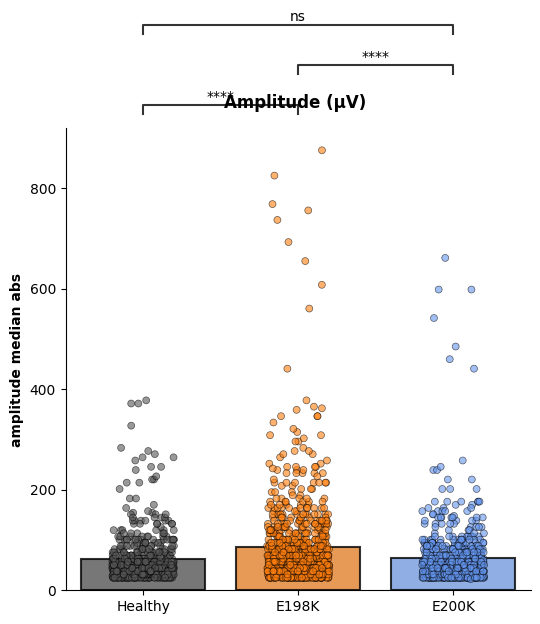

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x=x, y=y, order=order, palette=palette,
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x=x, y=y, order=order, palette=palette,



==================== STATISTICAL ANALYSIS: amplitude_median_abs ====================
Healthy vs E198K: p=2.1145e-09 (***), d=-0.311
Healthy vs E200K: p=7.5977e-01 (ns), d=-0.018
E198K vs E200K: p=3.2178e-08 (***), d=0.281
         Comparison    t-stat         p-val  Sig  Cohen's d
0  Healthy vs E198K -6.028866  2.114539e-09  ***  -0.310998
1  Healthy vs E200K -0.305855  7.597683e-01   ns  -0.017618
2    E198K vs E200K  5.558264  3.217827e-08  ***   0.280648
✅ PDF saved to: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/Amplitude_all_units_DOC14.pdf


In [8]:
import importlib
import meaplotter
importlib.reload(meaplotter)

# The Vibrant Palette from your image
vibrant_palette = {
    'Healthy': '#555555',       # Dark gray (the bar in your image)
    'E198K': '#ff7f0e',         # Vibrant orange
    'E200K': 'cornflowerblue'   # Vibrant blue
}

# Initialize
viz = meaplotter.MEAPlotter()

# 1. ANALYZE (Get the numbers)


# 2. PLOT (Just visualize in Jupyter)
fig, ax = plt.subplots(figsize=(6,6))

viz.plot_bars(
    df=df_all_thresholded,
    x='NeuronType',
    y='amplitude_median_abs',
    order=['Healthy', 'E198K', 'E200K'],
    palette=vibrant_palette,
    title="Amplitude (µV) ",
    ax=ax
)
plt.show()
stats_df = viz.calculate_stats(
    df=df_all_thresholded, 
    x='NeuronType', 
    y='amplitude_median_abs',
    order=['Healthy', 'E198K', 'E200K']
)
print(stats_df) # View stats if you want
# 3. SAVE PDF (Optional: Combine both into a report)
viz.save_pdf(
    df=df_all_thresholded,
    x='NeuronType',
    y='amplitude_median_abs',
    order=['Healthy', 'E198K', 'E200K'],
    palette=vibrant_palette,
    stats_df=stats_df,  # Pass the stats you calculated in step 1
    title="Amplitude (µV)",
    filename="/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/Amplitude_all_units_DOC14.pdf"
)

In [9]:
#random 5 units in top 90 percentile of amplitude_median_abs for each group
top_random_units = df_all_thresholded.groupby('NeuronType').apply(lambda x: x.nlargest(int(len(x)*0.15), 'amplitude_median_abs').sample(10, random_state=42)).reset_index(drop=True)
print(top_random_units[['NeuronType', 'amplitude_median_abs','Source_Well', 'Unnamed: 0']])


   NeuronType  amplitude_median_abs Source_Well  Unnamed: 0
0       E198K            214.004517     well003         240
1       E198K            239.181519     well001          46
2       E198K            314.712524     well002         271
3       E198K            258.064270     well000         288
4       E198K            144.767761     well003          15
5       E198K            207.710266     well000         229
6       E198K            182.533264     well002         108
7       E198K            151.062012     well003          96
8       E198K            169.944763     well004         207
9       E198K            276.947021     well002         233
10      E200K            107.002258     well001         109
11      E200K            144.767761     well005          31
12      E200K             94.413757     well004          50
13      E200K            176.239014     well004         104
14      E200K            100.708008     well005          55
15      E200K            100.708008     

/tmp/ipykernel_577752/3641273811.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_random_units = df_all_thresholded.groupby('NeuronType').apply(lambda x: x.nlargest(int(len(x)*0.15), 'amplitude_median_abs').sample(10, random_state=42)).reset_index(drop=True)


In [91]:
import spikeinterface.full as si
#from spikeinterface.extractors import WaveformExtractor

we = si.load("/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M05506/Network/000028/well004/analyzer_output/")

In [92]:
waveforms = we.get_extension("waveforms")

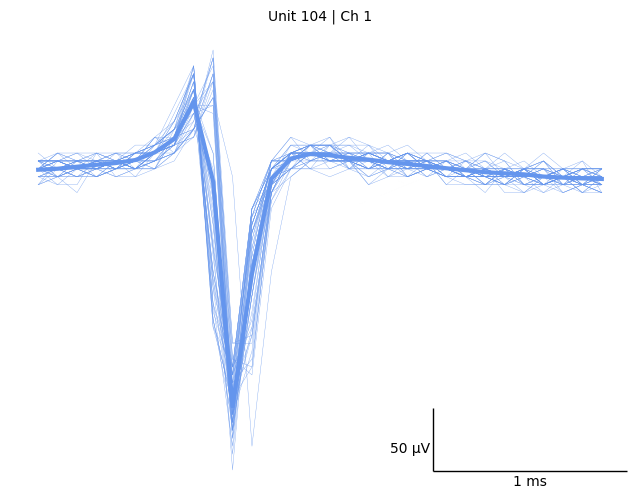

In [94]:
from scalebury import add_scalebar
neuron_type = "E200K"
uid = 104
vibrant_palette = {
    'Healthy': '#555555',       # Dark gray (the bar in your image)
    'E198K': '#ff7f0e',         # Vibrant orange
    'E200K': 'cornflowerblue'   # Vibrant blue
}
fig = plt.figure(figsize=(8,6))
wf = waveforms.get_waveforms_one_unit(uid)
mean_wf = np.mean(wf, axis=0)
best_ch = np.argmin(np.min(mean_wf, axis=0))

# [2] Create time vector in milliseconds
# (NumSamples / fs) * 1000
time_ms = np.arange(wf.shape[1]) /10000 * 1000

# Random subset logic
n_spikes = wf.shape[0]
if n_spikes > 100:
    np.random.seed(42)  # For reproducibility
    selected_indices = np.random.choice(n_spikes, size=50, replace=False)
    wf = wf[selected_indices]

spikes_to_plot = wf[:, :, best_ch]

# [3] Plot against time_ms (X-axis)
plt.plot(time_ms, spikes_to_plot.T, c=vibrant_palette[neuron_type], lw=0.25, alpha=0.9)
plt.plot(time_ms, mean_wf[:, best_ch], c=vibrant_palette[neuron_type], lw=3)

plt.title(f"Unit {uid} | Ch {best_ch}", fontsize=10)

add_scalebar(fig.axes[0], 
            matchx=False, matchy=False, 
            sizex=1.0, labelx='1 ms', 
            sizey=50, labely='50 µV', 
            loc='lower right', 
            hidex=True, hidey=True)
plt.savefig(f"/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/{neuron_type}Unit{uid}_waveform.svg", dpi=300, format='svg')
plt.show()

In [40]:
df_all_thresholded.columns

Index(['Source_Well', 'Unnamed: 0', 'num_spikes', 'firing_rate',
       'presence_ratio', 'snr', 'isi_violations_ratio', 'isi_violations_count',
       'rp_contamination', 'rp_violations', 'sliding_rp_violation',
       'amplitude_cutoff', 'amplitude_median', 'amplitude_cv_median',
       'amplitude_cv_range', 'sync_spike_2', 'sync_spike_4', 'sync_spike_8',
       'firing_range', 'sd_ratio', 'noise_cutoff', 'noise_ratio', 'loc_x',
       'loc_y', 'NeuronType', 'amplitude_median_abs'],
      dtype='object')

In [41]:
#top 5 units in each group
top_5_units = df_all_thresholded.groupby('NeuronType').apply(lambda x: x.nlargest(5, 'amplitude_median_abs')).reset_index(drop=True)
print(top_5_units[['NeuronType', 'amplitude_median_abs','Source_Well', 'Unnamed: 0']])

   NeuronType  amplitude_median_abs Source_Well  Unnamed: 0
0       E198K            874.900818     well000         186
1       E198K            824.546814     well002          22
2       E198K            767.898560     well000         295
3       E198K            755.310059     well001          10
4       E198K            736.427307     well002          33
5       E200K            660.896301     well001         202
6       E200K            597.953796     well001         195
7       E200K            597.953796     well001         203
8       E200K            541.305542     well003           6
9       E200K            484.657288     well003          10
10    Healthy            377.655029     well001          71
11    Healthy            371.360779     well001          32
12    Healthy            371.360779     well001          77
13    Healthy            327.301025     well005          72
14    Healthy            283.241272     well002         106


/tmp/ipykernel_3637971/3542484559.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_units = df_all_thresholded.groupby('NeuronType').apply(lambda x: x.nlargest(5, 'amplitude_median_abs')).reset_index(drop=True)


In [18]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Fit 2-component GMM
amps = df_all['amplitude_median_abs'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(amps)

# Identify which component is "noise" (lower mean)
means = gmm.means_.flatten()
noise_component = np.argmin(means)

# Predict cluster labels
labels = gmm.predict(amps)

# Keep only the "signal" cluster
signal_component = np.argmax(means)
df_curated = df_all[labels == signal_component]

# Report threshold
threshold_amp = gmm.means_[noise_component] + 2*np.sqrt(gmm.covariances_[noise_component][0,0])
#print(f"Amplitude threshold (noise mean + 2): {threshold_amp:.1f} µV")
print(threshold_amp)


[79.19277354]


/tmp/ipykernel_1377691/2541449657.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Neuron Type')


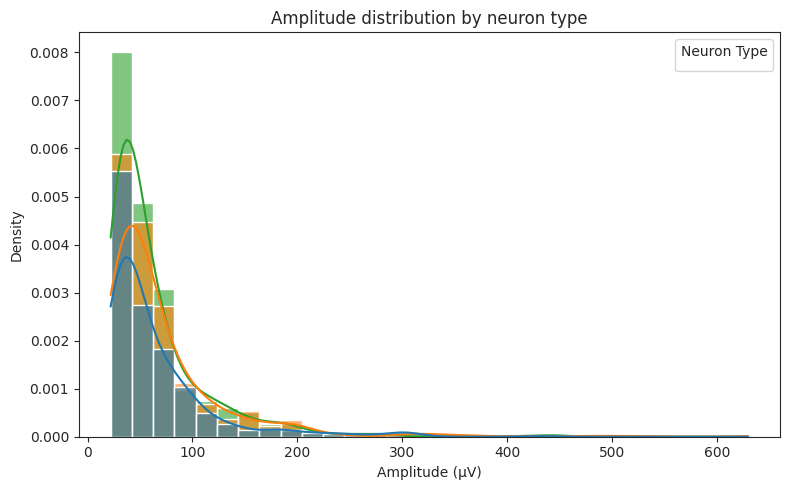

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

sns.histplot(
    data=df_all,
    x='amplitude_median_abs',
    hue='NeuronType',
    hue_order=['Healthy', 'E198K', 'E200K'],  # Ensure consistent order
    bins=30,
    alpha=0.6,          # transparency so you can see overlap
    kde=True,           # optional: add density curve
    stat='density'      # optional: normalize to probability density
)

plt.xlabel('Amplitude (µV)')
plt.ylabel('Density')
plt.title('Amplitude distribution by neuron type')
plt.legend(title='Neuron Type')
plt.tight_layout()
plt.show()



==================== STATISTICAL ANALYSIS: firing_rate ====================
Healthy (n=5) vs E198K (n=6): p=1.0503e-01 (ns), d=1.283
Healthy (n=5) vs E200K (n=6): p=1.0359e-01 (ns), d=-1.114
E198K (n=6) vs E200K (n=6): p=2.1908e-03 (**), d=-3.038
         Comparison       Grp1_Stats       Grp2_Stats    t-stat     p-val Sig  \
0  Healthy vs E198K  3.5 ± 0.5 (n=5)  2.6 ± 0.1 (n=6)  2.037246  0.105032  ns   
1  Healthy vs E200K  3.5 ± 0.5 (n=5)  4.6 ± 0.4 (n=6) -1.830935  0.103593  ns   
2    E198K vs E200K  2.6 ± 0.1 (n=6)  4.6 ± 0.4 (n=6) -5.261109  0.002191  **   

   Cohen's d  
0   1.282519  
1  -1.114270  
2  -3.037503  


/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  # 3. Add Significance Brackets (Calculates its own stats for placement)
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  annotator.configure(test='t-test_welch', text_format='star', loc='outside', verbose=False)


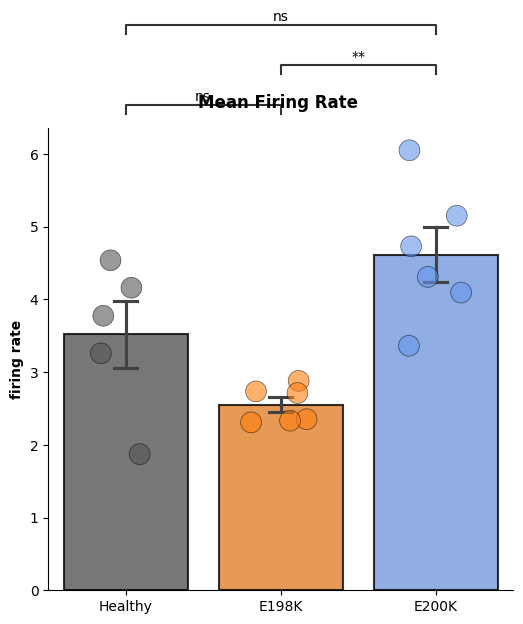

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  # 3. Add Significance Brackets (Calculates its own stats for placement)
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  annotator.configure(test='t-test_welch', text_format='star', loc='outside', verbose=False)


✅ PDF saved to: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/Firing_Rate_Report.pdf


In [113]:
import sys
import importlib
import matplotlib.pyplot as plt

# 1. Load the tool
sys.path.append('/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis')
import meaplotter
importlib.reload(meaplotter)

# 2. YOUR PRE-PROCESSING (Steps 1 & 2 from your script)
# Filter
df_clean = df_all[df_all['firing_rate'] >= 0.1].copy()

# Aggregate to Well Means (Crucial Step!)
# If you skip this, the plotter will plot every single electrode as a dot (N=Thousands)
df_well_means = df_clean.groupby(['NeuronType', 'Source_Well'])['firing_rate'].mean().reset_index()

import sys
import importlib
# sys.path.append('/your/path')
import meaplotter
importlib.reload(meaplotter)

# The Vibrant Palette from your image
vibrant_palette = {
    'Healthy': '#555555',       # Dark gray (the bar in your image)
    'E198K': '#ff7f0e',         # Vibrant orange
    'E200K': 'cornflowerblue'   # Vibrant blue
}

# Initialize
viz = meaplotter.MEAPlotter()

# 1. ANALYZE (Get the numbers)
stats_df = viz.calculate_stats(
    df=df_well_means, 
    x='NeuronType', 
    y='firing_rate',
    order=['Healthy', 'E198K', 'E200K']
)
print(stats_df) # View stats if you want

# 2. PLOT (Just visualize in Jupyter)
fig, ax = plt.subplots(figsize=(6,6))

viz.plot_bars(
    df=df_well_means,
    x='NeuronType',
    y='firing_rate',
    order=['Healthy', 'E198K', 'E200K'],
    palette=vibrant_palette,
    title="Mean Firing Rate ",
    ax=ax
)
plt.show()

# 3. SAVE PDF (Optional: Combine both into a report)
viz.save_pdf(
    df=df_well_means,
    x='NeuronType',
    y='firing_rate',
    order=['Healthy', 'E198K', 'E200K'],
    palette=vibrant_palette,
    stats_df=stats_df,  # Pass the stats you calculated in step 1
    title="Mean Firing Rate",
    filename="/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/Firing_Rate_Report.pdf"
)


==================== STATISTICAL ANALYSIS: amplitude_median_abs ====================
Healthy (n=5) vs E198K (n=6): p=6.3429e-02 (ns), d=-1.307
Healthy (n=5) vs E200K (n=6): p=5.1660e-01 (ns), d=-0.400
E198K (n=6) vs E200K (n=6): p=1.6996e-01 (ns), d=0.860
         Comparison        Grp1_Stats        Grp2_Stats    t-stat     p-val  \
0  Healthy vs E198K  63.0 ± 3.0 (n=5)  81.8 ± 7.8 (n=6) -2.239631  0.063429   
1  Healthy vs E200K  63.0 ± 3.0 (n=5)  67.4 ± 5.7 (n=6) -0.680616  0.516596   
2    E198K vs E200K  81.8 ± 7.8 (n=6)  67.4 ± 5.7 (n=6)  1.489938  0.169964   

  Sig  Cohen's d  
0  ns  -1.307337  
1  ns  -0.400409  
2  ns   0.860216  


/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  # 3. Add Significance Brackets (Calculates its own stats for placement)
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  annotator.configure(test='t-test_welch', text_format='star', loc='outside', verbose=False)


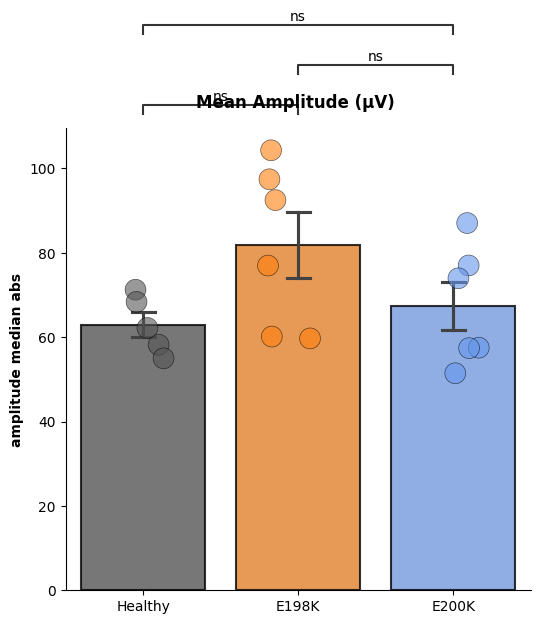

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  # 3. Add Significance Brackets (Calculates its own stats for placement)
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  annotator.configure(test='t-test_welch', text_format='star', loc='outside', verbose=False)


✅ PDF saved to: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/Amplitude_Report.pdf


In [100]:
import sys
import importlib
import matplotlib.pyplot as plt

# 1. Load the tool
sys.path.append('/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis')
import meaplotter
importlib.reload(meaplotter)

# 2. YOUR PRE-PROCESSING (Steps 1 & 2 from your script)
# Filter

df_all['amplitude_median_abs'] = np.abs(df_all['amplitude_median'])
df_clean = df_all[df_all['amplitude_median_abs'] >= 20].copy()
# ---------------------------------------------------------
# 2. AGGREGATE: Calculate Well Means
# ---------------------------------------------------------
df_well_means = df_clean.groupby(['NeuronType', 'Source_Well'])['amplitude_median_abs'].mean().reset_index()



# The Vibrant Palette from your image
vibrant_palette = {
    'Healthy': '#555555',       # Dark gray (the bar in your image)
    'E198K': '#ff7f0e',         # Vibrant orange
    'E200K': 'cornflowerblue'   # Vibrant blue
}

# Initialize
viz = meaplotter.MEAPlotter()

# 1. ANALYZE (Get the numbers)
stats_df = viz.calculate_stats(
    df=df_well_means, 
    x='NeuronType', 
    y='amplitude_median_abs',
    order=['Healthy', 'E198K', 'E200K']
)
print(stats_df) # View stats if you want

# 2. PLOT (Just visualize in Jupyter)
fig, ax = plt.subplots(figsize=(6,6))

viz.plot_bars(
    df=df_well_means,
    x='NeuronType',
    y='amplitude_median_abs',
    order=['Healthy', 'E198K', 'E200K'],
    palette=vibrant_palette,
    title="Mean Amplitude (µV) ",
    ax=ax
)
plt.show()

# 3. SAVE PDF (Optional: Combine both into a report)
viz.save_pdf(
    df=df_well_means,
    x='NeuronType',
    y='amplitude_median_abs',
    order=['Healthy', 'E198K', 'E200K'],
    palette=vibrant_palette,
    stats_df=stats_df,  # Pass the stats you calculated in step 1
    title="Mean Amplitude (µV) ",
    filename="/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/Amplitude_Report.pdf"
)

In [101]:
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Setup Paths
# ---------------------------------------------------------
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08018/Network/000021/"
output_filename = "merged_template_metrics_healthy.xlsx"

# Define the range of wells (well000 to well005)
wells = [f"well{i:03d}" for i in range(6)]

# ---------------------------------------------------------
# 2. Collect and Merge Data
# ---------------------------------------------------------
dfs = []

print(f"Scanning directories in: {base_path}\n")

for well in wells:
    # Construct the full file path
    file_path = os.path.join(base_path, well, "tm_curated.xlsx")
    
    if os.path.exists(file_path):
        try:
            # Load the Excel file
            df = pd.read_excel(file_path)
            
            # Add a 'Well' column so you know which file the row came from
            df.insert(0, 'Source_Well', well)
            
            # Add to list
            dfs.append(df)
            print(f"[SUCCESS] Loaded: {well}/tm_curated.xlsx ({len(df)} rows)")
            
        except Exception as e:
            print(f"[ERROR] Could not read {well}: {e}")
    else:
        print(f"[WARNING] File not found: {file_path}")

# ---------------------------------------------------------
# 3. Concatenate and Save
# ---------------------------------------------------------
if dfs:
    merged_tm_df_healthy = pd.concat(dfs, ignore_index=True)
    
    # Save the merged file to the base directory
    output_path = os.path.join(base_path, output_filename)
    merged_tm_df_healthy["NeuronType"] = "Healthy"  # Add NeuronType column with "Healthy" value
    merged_tm_df_healthy.to_excel(output_path, index=False)
    
    print("-" * 50)
    print(f"Merge Complete!")
    print(f"Total Rows: {len(merged_tm_df_healthy)}")
    print(f"Saved to:   {output_path}")
    
    # Display first few rows
    print("\nPreview of merged data:")
    print(merged_tm_df_healthy.head())
else:
    print("\n[ERROR] No files were loaded. Please check your paths.")

Scanning directories in: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08018/Network/000021/

[SUCCESS] Loaded: well000/tm_curated.xlsx (64 rows)
[SUCCESS] Loaded: well001/tm_curated.xlsx (118 rows)
[SUCCESS] Loaded: well002/tm_curated.xlsx (135 rows)
[SUCCESS] Loaded: well003/tm_curated.xlsx (78 rows)
[WARNING] File not found: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08018/Network/000021/well004/tm_curated.xlsx
[SUCCESS] Loaded: well005/tm_curated.xlsx (139 rows)
--------------------------------------------------
Merge Complete!
Total Rows: 534
Saved to:   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08018/Network/000021/merged_template_metrics_healthy.xlsx

Preview of merged data:
  Source_Well  Unnamed: 0  peak_to_valley  peak_trough_ratio  half_width  \
0     w

In [102]:
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Setup Paths
# ---------------------------------------------------------
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08020/Network/000024/"
output_filename = "merged_template_metrics_e198.xlsx"

# Define the range of wells (well000 to well005)
wells = [f"well{i:03d}" for i in range(6)]

# ---------------------------------------------------------
# 2. Collect and Merge Data
# ---------------------------------------------------------
dfs = []

print(f"Scanning directories in: {base_path}\n")

for well in wells:
    # Construct the full file path
    file_path = os.path.join(base_path, well, "tm_curated.xlsx")
    
    if os.path.exists(file_path):
        try:
            # Load the Excel file
            df = pd.read_excel(file_path)
            
            # Add a 'Well' column so you know which file the row came from
            df.insert(0, 'Source_Well', well)
            
            # Add to list
            dfs.append(df)
            print(f"[SUCCESS] Loaded: {well}/tm_curated.xlsx ({len(df)} rows)")
            
        except Exception as e:
            print(f"[ERROR] Could not read {well}: {e}")
    else:
        print(f"[WARNING] File not found: {file_path}")

# ---------------------------------------------------------
# 3. Concatenate and Save
# ---------------------------------------------------------
if dfs:
    merged_tm_df_e198 = pd.concat(dfs, ignore_index=True)
    
    # Save the merged file to the base directory
    output_path = os.path.join(base_path, output_filename)
    merged_tm_df_e198["NeuronType"] = "E198K"  # Add NeuronType column with "E198" value
    merged_tm_df_e198.to_excel(output_path, index=False)
    
    print("-" * 50)
    print(f"Merge Complete!")
    print(f"Total Rows: {len(merged_tm_df_e198)}")
    print(f"Saved to:   {output_path}")
    
    # Display first few rows
    print("\nPreview of merged data:")
    print(merged_tm_df_e198.head())
else:
    print("\n[ERROR] No files were loaded. Please check your paths.")

Scanning directories in: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08020/Network/000024/

[SUCCESS] Loaded: well000/tm_curated.xlsx (206 rows)
[SUCCESS] Loaded: well001/tm_curated.xlsx (157 rows)
[SUCCESS] Loaded: well002/tm_curated.xlsx (151 rows)
[SUCCESS] Loaded: well003/tm_curated.xlsx (141 rows)
[SUCCESS] Loaded: well004/tm_curated.xlsx (99 rows)
[SUCCESS] Loaded: well005/tm_curated.xlsx (109 rows)
--------------------------------------------------
Merge Complete!
Total Rows: 863
Saved to:   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M08020/Network/000024/merged_template_metrics_e198.xlsx

Preview of merged data:
  Source_Well  Unnamed: 0  peak_to_valley  peak_trough_ratio  half_width  \
0     well000           1         0.00157          -0.145138     0.00185   
1     well000           3         0.00134          -0.062245     0.000

In [103]:
import pandas as pd
import os

# ---------------------------------------------------------
# 1. Setup Paths
# ---------------------------------------------------------
base_path = "/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M05506/Network/000028/"
output_filename = "merged_template_metrics_e200.xlsx"

# Define the range of wells (well000 to well005)
wells = [f"well{i:03d}" for i in range(6)]

# ---------------------------------------------------------
# 2. Collect and Merge Data
# ---------------------------------------------------------
dfs = []

print(f"Scanning directories in: {base_path}\n")

for well in wells:
    # Construct the full file path
    file_path = os.path.join(base_path, well, "tm_curated.xlsx")
    
    if os.path.exists(file_path):
        try:
            # Load the Excel file
            df = pd.read_excel(file_path)
            
            # Add a 'Well' column so you know which file the row came from
            df.insert(0, 'Source_Well', well)
            
            # Add to list
            dfs.append(df)
            print(f"[SUCCESS] Loaded: {well}/tm_curated.xlsx ({len(df)} rows)")
            
        except Exception as e:
            print(f"[ERROR] Could not read {well}: {e}")
    else:
        print(f"[WARNING] File not found: {file_path}")

# ---------------------------------------------------------
# 3. Concatenate and Save
# ---------------------------------------------------------
if dfs:
    merged_tm_df_e200 = pd.concat(dfs, ignore_index=True)
    
    # Save the merged file to the base directory
    output_path = os.path.join(base_path, output_filename)
    merged_tm_df_e200["NeuronType"] = "E200K"  # Add NeuronType column with "E200" value
    merged_tm_df_e200.to_excel(output_path, index=False)
    
    print("-" * 50)
    print(f"Merge Complete!")
    print(f"Total Rows: {len(merged_tm_df_e200)}")
    print(f"Saved to:   {output_path}")
    
    # Display first few rows
    print("\nPreview of merged data:")
    print(merged_tm_df_e200.head())
else:
    print("\n[ERROR] No files were loaded. Please check your paths.")

Scanning directories in: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M05506/Network/000028/

[SUCCESS] Loaded: well000/tm_curated.xlsx (63 rows)
[SUCCESS] Loaded: well001/tm_curated.xlsx (115 rows)
[SUCCESS] Loaded: well002/tm_curated.xlsx (124 rows)
[SUCCESS] Loaded: well003/tm_curated.xlsx (109 rows)
[SUCCESS] Loaded: well004/tm_curated.xlsx (92 rows)
[SUCCESS] Loaded: well005/tm_curated.xlsx (157 rows)
--------------------------------------------------
Merge Complete!
Total Rows: 660
Saved to:   /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/250122/M05506/Network/000028/merged_template_metrics_e200.xlsx

Preview of merged data:
  Source_Well  Unnamed: 0  peak_to_valley  peak_trough_ratio  half_width  \
0     well000           2         0.00046          -0.117837     0.00020   
1     well000           3         0.00034          -0.089940     0.0001

In [104]:
#now merge all three dataframes together
df_tm_all = pd.concat([merged_tm_df_healthy, merged_tm_df_e198, merged_tm_df_e200], axis=0, ignore_index=True)
print(f"Combined DataFrame shape: {df_tm_all.shape}")
print(df_tm_all['NeuronType'].value_counts())

Combined DataFrame shape: (2057, 10)
NeuronType
E198K      863
E200K      660
Healthy    534
Name: count, dtype: int64


In [105]:
df_tm_all.columns

Index(['Source_Well', 'Unnamed: 0', 'peak_to_valley', 'peak_trough_ratio',
       'half_width', 'repolarization_slope', 'recovery_slope',
       'num_positive_peaks', 'num_negative_peaks', 'NeuronType'],
      dtype='object')

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  # 3. Add Significance Brackets (Calculates its own stats for placement)
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  annotator.configure(test='t-test_welch', text_format='star', loc='outside', verbose=False)


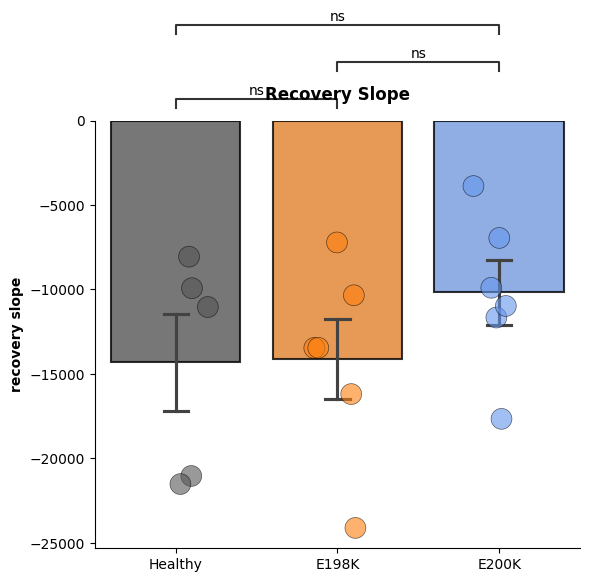

/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  # 3. Add Significance Brackets (Calculates its own stats for placement)
/mnt/Vol20tb1/user_workspaces/mmpatil/MEA_Analysis/IPNAnalysis/meaplotter.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  annotator.configure(test='t-test_welch', text_format='star', loc='outside', verbose=False)



==================== STATISTICAL ANALYSIS: recovery_slope ====================
Healthy (n=5) vs E198K (n=6): p=9.6130e-01 (ns), d=-0.030
Healthy (n=5) vs E200K (n=6): p=2.6852e-01 (ns), d=-0.737
E198K (n=6) vs E200K (n=6): p=2.2224e-01 (ns), d=-0.754
✅ PDF saved to: /mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/recovery_slope_DIV14.pdf


In [112]:
import sys
import importlib
import matplotlib.pyplot as plt

# Reload your plotter
import meaplotter
importlib.reload(meaplotter)

# ---------------------------------------------------------
# 1. SETUP & AGGREGATE
# ---------------------------------------------------------
template_metric = 'recovery_slope'  # Change this to whatever metric you want to plot from the tm_curated.xlsx fi

# Aggregate to well-level means
df_tm_well_means = df_tm_all.groupby(['NeuronType', 'Source_Well'])[template_metric].mean().reset_index()

# ---------------------------------------------------------
# 2. PLOT WITH MEAPLOTTER
# ---------------------------------------------------------
viz = meaplotter.MEAPlotter()
vibrant_palette = {'Healthy': '#555555', 'E198K': '#ff7f0e', 'E200K': 'cornflowerblue'}

fig, ax = plt.subplots(figsize=(6, 6))

# Let MEAPlotter handle everything naturally for positive data
viz.plot_bars(
    df=df_tm_well_means,
    x='NeuronType',
    y=template_metric,
    order=['Healthy', 'E198K', 'E200K'],
    palette=vibrant_palette,
    title=f"{template_metric.replace('_', ' ').title()}", # Updated title!
    ax=ax
)

# ---------------------------------------------------------
# 3. SAVE & SHOW (No manual ylim hacks needed!)
# ---------------------------------------------------------
plt.tight_layout()
save_path = f"/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/{template_metric}_DIV14.svg"
plt.savefig(save_path, dpi=300, format='svg')
plt.show()

# PDF Report Generation
stats_df = viz.calculate_stats(df_tm_well_means, x='NeuronType', y=template_metric, order=['Healthy', 'E198K', 'E200K'])
viz.save_pdf(df_tm_well_means, 'NeuronType', template_metric, ['Healthy', 'E198K', 'E200K'], stats_df, vibrant_palette, title=f"{template_metric.replace('_', ' ').title()}", filename=save_path.replace('.svg', '.pdf'))

Stats Results (Welch's t-test):
  Healthy vs E198K: p = 0.1426
  Healthy vs E200K: p = 0.1613


/tmp/ipykernel_1377691/2403143563.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_1377691/2403143563.py:62: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


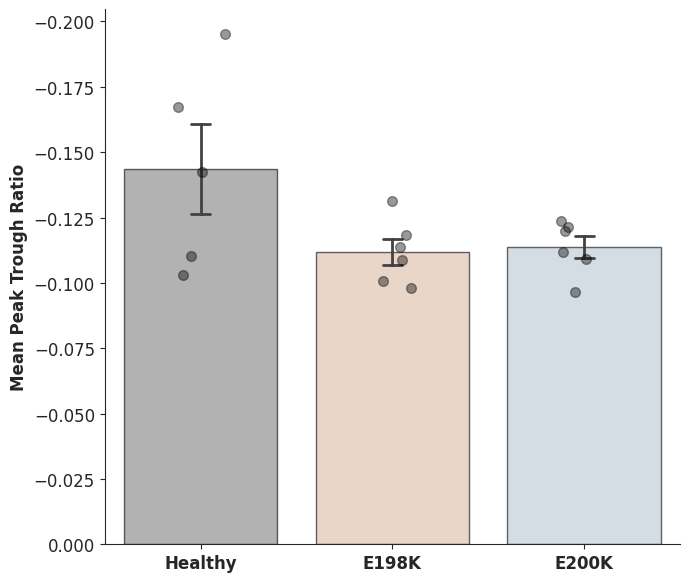

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# ---------------------------------------------------------
# 1. SETUP: Define Order and Filter Data
# ---------------------------------------------------------
order_list = ['Healthy', 'E198K', 'E200K']
#df_tm_clean = df_tm_all[df_tm_all['firing_rate'] >= 0.1].copy()
df_tm_clean = df_tm_all.copy() # No thresholding for template metrics
template_metrics ='peak_trough_ratio' # Change this to the desired template metric column name
# ---------------------------------------------------------
# 2. AGGREGATE: Calculate Well Means
# ---------------------------------------------------------
df_tm_well_means = df_tm_clean.groupby(['NeuronType', 'Source_Well'])[template_metrics].mean().reset_index()

# ---------------------------------------------------------
# 3. STATS: Welch's T-Test
# ---------------------------------------------------------
# Extract the firing rates for each group
healthy = df_tm_well_means[df_tm_well_means['NeuronType'] == 'Healthy'][template_metrics]
e198k = df_tm_well_means[df_tm_well_means['NeuronType'] == 'E198K'][template_metrics]
e200k = df_tm_well_means[df_tm_well_means['NeuronType'] == 'E200K'][template_metrics]

# Perform pairwise t-tests (Welch's: equal_var=False)
t_198, p_198 = stats.ttest_ind(healthy, e198k, equal_var=False)
t_200, p_200 = stats.ttest_ind(healthy, e200k, equal_var=False)

print(f"Stats Results (Welch's t-test):")
print(f"  Healthy vs E198K: p = {p_198:.4f}")
print(f"  Healthy vs E200K: p = {p_200:.4f}")

# Helper function to convert p-value to stars
def get_stars(p):
    if p < 0.001: return '***'
    if p < 0.01:  return '**'
    if p < 0.05:  return '*'
    return 'ns'

# ---------------------------------------------------------
# 4. PLOTTING
# ---------------------------------------------------------
plt.figure(figsize=(7, 6))
sns.set_style("ticks") # Clean white background style

# A. Bar Plot (Mean + SE)
ax = sns.barplot(
    data=df_tm_well_means,
    x='NeuronType',
    y=template_metrics,
    order=order_list,     # <--- ENFORCED ORDER
    errorbar='se',
    capsize=0.1,
    alpha=0.6,
    palette=['gray', '#E6B89C', '#B4C5D6'], # Custom colors matching your reference image
    edgecolor='black',
    err_kws={'linewidth': 2}
)

# B. Strip Plot (Individual Wells)
sns.stripplot(
    data=df_tm_well_means,
    x='NeuronType',
    y=template_metrics,
    order=order_list,     # <--- ENFORCED ORDER
    color='black',
    size=7,
    jitter=0.15,
    alpha=0.4,            # Transparent dots
    edgecolor='gray',     # Slight border on dots
    linewidth=1
)

# ---------------------------------------------------------
# 5. DRAW SIGNIFICANCE BARS
# ---------------------------------------------------------
# Get the max height to position bars above the data
y_max = df_tm_well_means[template_metrics].max()
h = y_max * 0.05  # Height of the bracket legs

# Function to draw bracket
def draw_bracket(idx1, idx2, p_val, y_pos):
    stars = get_stars(p_val)
    if stars == 'ns': return # Skip if not significant (optional)
    
    x1, x2 = idx1, idx2
    line_y = y_pos + h
    
    # Draw the bracket lines
    plt.plot([x1, x1, x2, x2], [y_pos, line_y, line_y, y_pos], lw=1.5, c='k')
    
    # Add the text (stars)
    plt.text((x1+x2)/2, line_y, stars, ha='center', va='bottom', color='k', fontsize=14, fontweight='bold')

# Draw brackets (0=Healthy, 1=E198K, 2=E200K)
# Adjust 'y_max + ...' multipliers to stack brackets nicely
draw_bracket(0, 1, p_198, y_max + (y_max * 0.1))
draw_bracket(0, 2, p_200, y_max + (y_max * 0.25))

# ---------------------------------------------------------
# 6. FORMATTING
# ---------------------------------------------------------
plt.ylabel(f'Mean {template_metrics.replace("_", " ").title()}', fontsize=12, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
sns.despine() # Removes top and right borders
plt.tight_layout()
plt.gca().invert_yaxis() # Invert y-axis if lower values indicate stronger effect (e.g., peak-trough ratio)
plt.savefig(f"/mnt/Vol20tb1/user_workspaces/shruti/MEA_Analysis/MEA_Analysis_V2/MEA_Analysis/AnalyzedData/JGA_CSB3_010825_VD/{template_metrics}_DIV19.svg", dpi=300, format='svg')
plt.show()